In [1]:
%matplotlib inline

In [1]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *

In [2]:
#The first time this will download a dataset that is ~650mb
path = untar_data(URLs.ESC50) 

The audio files are inside a subfolder `audio/`

In [3]:
(path/"audio").ls()

(#2000) [Path('/home/scart/.fastai/data/master/audio/5-198891-A-8.wav'),Path('/home/scart/.fastai/data/master/audio/3-128512-A-47.wav'),Path('/home/scart/.fastai/data/master/audio/4-234879-A-6.wav'),Path('/home/scart/.fastai/data/master/audio/3-100024-A-27.wav'),Path('/home/scart/.fastai/data/master/audio/5-263831-A-6.wav'),Path('/home/scart/.fastai/data/master/audio/1-22804-A-46.wav'),Path('/home/scart/.fastai/data/master/audio/2-117615-A-48.wav'),Path('/home/scart/.fastai/data/master/audio/5-221518-A-21.wav'),Path('/home/scart/.fastai/data/master/audio/2-43802-A-42.wav'),Path('/home/scart/.fastai/data/master/audio/5-194899-D-3.wav')...]

And there's another folder `meta/` with some metadata about all the files and the labels

In [4]:
(path/"meta").ls()

(#2) [Path('/home/scart/.fastai/data/master/meta/esc50.csv'),Path('/home/scart/.fastai/data/master/meta/esc50-human.xlsx')]

Opening the metadata file

In [5]:
df = pd.read_csv(path/"meta"/"esc50.csv")
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


Looking at the fold attribute, this dataset has a 5 fold cross validation setup

In [6]:
df["fold"].value_counts()

5    400
4    400
3    400
2    400
1    400
Name: fold, dtype: int64

## Datablock and Basic End to End Training on 10 Speakers

In [7]:
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [8]:
cfg = AudioConfig.BasicMelSpectrogram()
a2s = AudioToSpec.from_cfg(cfg)

In [9]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_x=ColReader("filename", pref=path/"audio"), 
                 splitter=CrossValidationSplitter(fold=1),
                 batch_tfms = [a2s],
                 get_y=ColReader("category"))

In [10]:
dbunch = auds.dataloaders(df, bs=64)

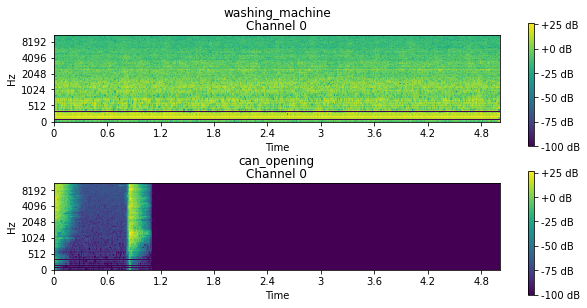

In [13]:
dbunch.show_batch(figsize=(10, 5))

# 10 epochs

In [37]:
accuracies = []

for i in range(5):
    learn = cnn_learner(dbunch, 
                    resnet18, 
                    config=cnn_config(n_in=1),
                    loss_fn=CrossEntropyLossFlat,
                    metrics=[accuracy]                 
                    )
    
    learn.fit_one_cycle(10)
    accuracies.append(learn.recorder.values[-1][-1])

print(sum(accuracies) / 5)

epoch,train_loss,valid_loss,accuracy,time
0,5.443365,3.867738,0.062500,00:05
1,4.430952,2.429274,0.367500,00:05
2,3.289633,1.870164,0.520000,00:05
3,2.430481,1.659231,0.560000,00:05
4,1.813092,1.515637,0.602500,00:05
5,1.372124,1.456632,0.632500,00:05
6,1.053167,1.440829,0.637500,00:05
7,0.846203,1.402059,0.647500,00:05
8,0.698500,1.389573,0.635000,00:05
9,0.626646,1.383566,0.637500,00:08


epoch,train_loss,valid_loss,accuracy,time
0,5.374907,3.894449,0.080000,00:08
1,4.420043,2.407643,0.362500,00:07
2,3.280751,1.827081,0.497500,00:07
3,2.415136,1.559717,0.565000,00:07
4,1.796064,1.429406,0.607500,00:08
5,1.341757,1.374672,0.620000,00:08
6,1.032111,1.341714,0.612500,00:08
7,0.829519,1.341242,0.615000,00:07
8,0.687244,1.336070,0.620000,00:08
9,0.609053,1.318514,0.625000,00:07


epoch,train_loss,valid_loss,accuracy,time
0,5.364762,3.825435,0.097500,00:07
1,4.364281,2.428854,0.350000,00:07
2,3.242001,1.810513,0.497500,00:07
3,2.386750,1.585670,0.542500,00:07
4,1.787803,1.455775,0.585000,00:08
5,1.361317,1.393362,0.597500,00:08
6,1.057468,1.365199,0.625000,00:08
7,0.855146,1.332770,0.617500,00:07
8,0.701642,1.319732,0.620000,00:07
9,0.606780,1.314981,0.620000,00:07


epoch,train_loss,valid_loss,accuracy,time
0,5.416254,3.887769,0.072500,00:07
1,4.384213,2.373110,0.405000,00:07
2,3.199247,1.791542,0.527500,00:07
3,2.372201,1.609312,0.567500,00:08
4,1.793090,1.512502,0.597500,00:07
5,1.360480,1.430899,0.627500,00:07
6,1.048600,1.381251,0.632500,00:08
7,0.851659,1.352315,0.637500,00:08
8,0.711122,1.330115,0.635000,00:08
9,0.624832,1.339744,0.630000,00:07


epoch,train_loss,valid_loss,accuracy,time
0,5.470612,3.974913,0.087500,00:07
1,4.473239,2.407490,0.367500,00:08
2,3.300419,1.808635,0.515000,00:07
3,2.413354,1.607943,0.562500,00:08
4,1.802979,1.541595,0.572500,00:07
5,1.367113,1.465795,0.590000,00:08
6,1.058643,1.438057,0.617500,00:07
7,0.856980,1.408205,0.622500,00:07
8,0.712561,1.405151,0.615000,00:07
9,0.625036,1.397497,0.622500,00:07


0.6269999980926514


# 20 epochs

In [36]:
accuracies = []

for i in range(5):
    learn = cnn_learner(dbunch, 
                    resnet18, 
                    config=cnn_config(n_in=1),
                    loss_fn=CrossEntropyLossFlat,
                    metrics=[accuracy]                 
                    )
    
    learn.fit_one_cycle(20)
    accuracies.append(learn.recorder.values[-1][-1])

print(sum(accuracies) / 5)

epoch,train_loss,valid_loss,accuracy,time
0,5.571576,4.236383,0.040000,00:05
1,5.060277,3.284567,0.190000,00:05
2,4.175367,2.381387,0.395000,00:05
3,3.278146,1.904522,0.507500,00:05
4,2.470563,1.693522,0.530000,00:05
5,1.870382,1.543609,0.557500,00:05
6,1.405936,1.413359,0.597500,00:05
7,1.075424,1.350571,0.582500,00:05
8,0.836482,1.345091,0.620000,00:05
9,0.663277,1.314712,0.637500,00:05


epoch,train_loss,valid_loss,accuracy,time
0,5.418221,4.106913,0.062500,00:05
1,4.912192,3.250856,0.182500,00:05
2,4.112569,2.340261,0.375000,00:05
3,3.213293,1.831323,0.482500,00:05
4,2.449731,1.633928,0.560000,00:05
5,1.866984,1.485480,0.595000,00:05
6,1.428316,1.339001,0.615000,00:05
7,1.086002,1.278471,0.625000,00:05
8,0.841078,1.246363,0.650000,00:05
9,0.662987,1.231850,0.672500,00:05


epoch,train_loss,valid_loss,accuracy,time
0,5.447973,4.056999,0.060000,00:05
1,5.000773,3.143332,0.212500,00:05
2,4.095160,2.238740,0.420000,00:05
3,3.205685,1.748865,0.535000,00:05
4,2.445203,1.535104,0.585000,00:05
5,1.876024,1.429539,0.615000,00:05
6,1.421342,1.373967,0.617500,00:05
7,1.098190,1.300745,0.640000,00:05
8,0.860720,1.259749,0.632500,00:07
9,0.662130,1.216794,0.667500,00:09


epoch,train_loss,valid_loss,accuracy,time
0,5.554028,4.267784,0.020000,00:07
1,5.074132,3.326456,0.167500,00:07
2,4.173484,2.340155,0.370000,00:07
3,3.230395,1.850368,0.500000,00:07
4,2.454459,1.634697,0.545000,00:07
5,1.852218,1.492712,0.565000,00:07
6,1.399523,1.390363,0.612500,00:07
7,1.086984,1.359946,0.620000,00:07
8,0.848832,1.332582,0.630000,00:07
9,0.669648,1.310373,0.632500,00:07


epoch,train_loss,valid_loss,accuracy,time
0,5.607564,4.281517,0.037500,00:07
1,5.026485,3.315955,0.135000,00:07
2,4.139828,2.349496,0.367500,00:07
3,3.236852,1.871185,0.475000,00:07
4,2.422250,1.668393,0.532500,00:07
5,1.830358,1.517292,0.537500,00:08
6,1.376796,1.422221,0.597500,00:08
7,1.049109,1.372798,0.597500,00:07
8,0.820410,1.320149,0.627500,00:07
9,0.647190,1.314800,0.615000,00:07


0.6664999961853028


# 80 epochs

In [14]:
accuracies = []


learn = cnn_learner(dbunch, 
                resnet18, 
                config=cnn_config(n_in=1),
                loss_fn=CrossEntropyLossFlat,
                metrics=[accuracy],
                cbs=[MixUp()] #<- Mixup
                )


learn.fit_one_cycle(80)

print(learn.recorder.values[-1][-1])

epoch,train_loss,valid_loss,accuracy,time
0,5.600182,4.542647,0.030000,00:05
1,5.477305,4.348933,0.045000,00:05
2,5.298264,4.039163,0.075000,00:05
3,5.055049,3.666168,0.112500,00:05
4,4.752405,3.248813,0.175000,00:05
5,4.406843,2.863571,0.257500,00:05
6,4.035123,2.549296,0.332500,00:05
7,3.660507,2.276012,0.402500,00:05
8,3.341847,2.050498,0.427500,00:05
9,3.047711,1.852929,0.472500,00:05


0.7825000286102295
